In [35]:
import magnonRPA as rpa
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import colors as mclr

### Plotting settings 
#plt.rc('figure', dpi=100)
#plt.rc('figure',figsize=(4,1.7))
plt.rc('font', family = 'Times New Roman')
plt.rc('font', size = 14)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=18)
plt.rc('lines', linewidth=2.5)

In [40]:
T = 0.6*rpa.t
U = 7.5*rpa.t
J = 4.*rpa.t**2/U
mu = -3*rpa.t ### Chemical potential 

figDirectory = "../figures/"
dataDirectory = "../data/"

saveFigs = False

holesDirectory = dataDirectory+"hole_spectra/03252025/"
holesFile = "Hole_Spectral_functionJz0.0_alfa0.999_Nx20_Ny20"#"Hole_Spectral_functionJz0.05_alfa0.999_Nx20_Ny20"

kxs,kys,ws,A = rpa.load_hole_spectrum(holesDirectory+holesFile)
kxvs,kyvs,wvs = np.meshgrid(kxs,kys,ws)
Nkx = len(kxs)
Nky = len(kys)
Nw = len(ws)

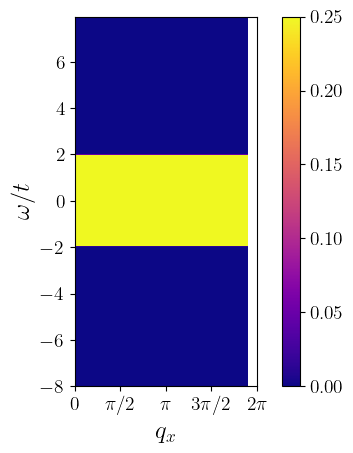

In [41]:
W = 4.*rpa.t
test_A = rpa.gen_box_A(kxs,kys,ws,W)

### Plot it to make sure 
plt.imshow(np.transpose(test_A[:,0,:]),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=0.8,cmap='plasma')
plt.ylabel(r'$\omega/t$')
plt.xlabel(r'$q_x$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.colorbar()
#if saveFigs: plt.savefig(figDirectory+"/Magnon_spectrum.pdf",bbox_inches='tight')
plt.show()

In [42]:
mu = -0.9*W/2.
delta = rpa.calc_density(kxs,kys,ws,test_A,mu,T)
print("Hole doping: {d:0.1%}".format(d=delta))

### Calculate RPA spectra from hole spectra 
ImPi0,ImPi1 = rpa.calc_ImPi(kxs,kys,ws,test_A,mu,T)
Pi0 = rpa.Kramers_Kronig(ws,ImPi0)
Pi1 = rpa.Kramers_Kronig(ws,ImPi1)



Hole doping: 12.7%


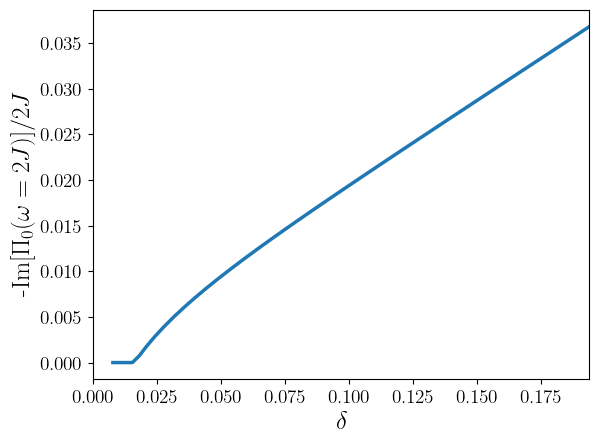

In [34]:
nmus = 40
mus = np.linspace(-1.05*W/2.,-0.6*W/2.,nmus)
deltas = np.array([ rpa.calc_density(kxs,kys,ws,test_A,mu,T) for mu in mus ])
dampings = np.array([ -rpa.box_Pi0(2.*J,W,mu) for mu in mus ])

plt.plot(deltas,dampings/(2.*J))
plt.xlim(0.,deltas[-1])
plt.xlabel(r'$\delta$')
plt.ylabel(r'-Im[$\Pi_0(\omega=2J)$]$/2J$')
plt.show()

In [24]:
### Magnon propagators 
magnon_kernel = rpa.RPA_kernel(kxs,kys,ws,Pi0,Pi1,J)
magnon_propagator = np.zeros_like(magnon_kernel)
spectral_eigenvalues = np.zeros((4,Nkx,Nky,Nw),dtype=complex)

for i in range(len(kxs)):
    for j in range(len(kys)):
        for k in range(len(ws)):
            magnon_propagator[:,:,i,j,k] = np.linalg.inv(magnon_kernel[:,:,i,j,k])
            eigvs = np.linalg.eig(magnon_propagator[:,:,i,j,k])[0]

            ### We sort first by imaginary part 
            ### Numpy sort automatically sorts by real so we multiply by i, sort, then unmultiply
            spectral_eigenvalues[:,i,j,k] = 1.j*np.sort(-1.j*eigvs)


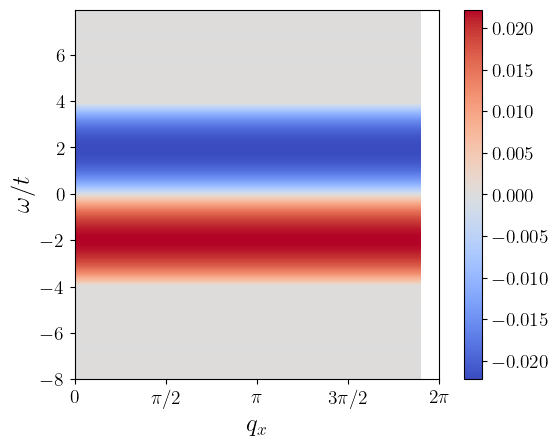

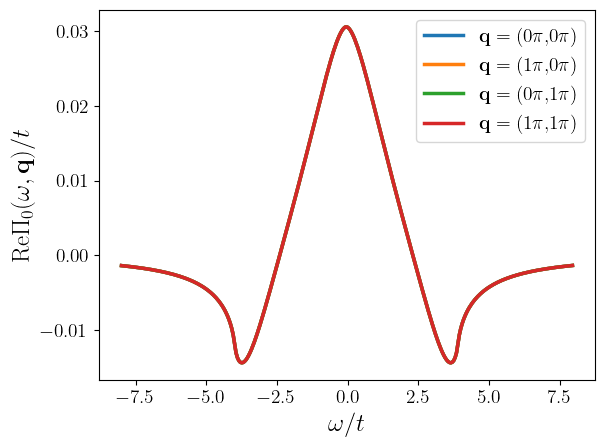

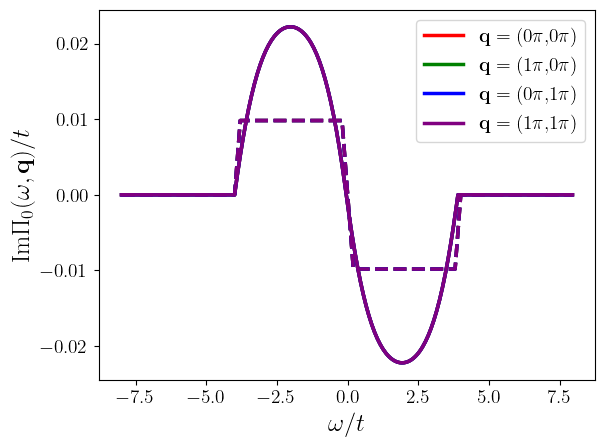

In [43]:
### Frequency cuts of magnon propagator spectral function trace 
indices = [ [0,0],[10,0],[0,10],[10,10]]
clrs = ['red','green','blue','purple']
label_strings = [ r'$\mathbf{q}=($'+"{qx:0.0f}".format(qx=kxs[i[0]]/np.pi) + r'$\pi,$' + "{qy:0.0f}".format(qy=kys[i[1]]/np.pi) + r'$\pi)$'  for i in indices]


### Frequency dependence of Pi for kx cut 
plt.imshow(np.transpose(ImPi0[:,0,:]),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=0.4,cmap='coolwarm')
plt.xlabel(r'$q_x$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.ylabel(r'$\omega/t$')
plt.colorbar()
if saveFigs: plt.savefig(figDirectory+"/ImPi0_w_qx.pdf",bbox_inches='tight')
plt.show()

### Frequency cuts of polarizations of magnons
if True:
    for j in range(len(indices)):
        i = indices[j]
        plt.plot(ws/rpa.t,np.real(Pi0[i[0],i[1],:])/rpa.t,label=label_strings[j])
    
    plt.xlabel(r'$\omega/t$')
    plt.ylabel(r'Re$\Pi_0(\omega,\mathbf{q})/t$')
    plt.legend()
    if saveFigs: plt.savefig(figDirectory+"/RePi0.pdf",bbox_inches='tight')
    plt.show()


if True:
    for j in range(len(indices)):
        i = indices[j]
        plt.plot(ws/rpa.t,np.imag(Pi0[i[0],i[1],:])/rpa.t,label=label_strings[j],color=clrs[j])
        plt.plot(ws/rpa.t,np.array([rpa.box_Pi0(w,W,mu) for w in ws ]),color=clrs[j],linestyle='dashed')

    plt.xlabel(r'$\omega/t$')
    plt.ylabel(r'Im$\Pi_0(\omega,\mathbf{q})/t$')
    plt.legend()
    if saveFigs: plt.savefig(figDirectory+"/ImPi0.pdf",bbox_inches='tight')
    plt.show()


/var/folders/hl/gwthrswx1clcrvqp3t0pjtxw0000gn/T/ipykernel_69229/232122749.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(np.transpose(-1./np.pi*np.imag(spectral_eigenvalues[i,:,0,:])/wvs[:,0,:]),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=1.4,cmap='coolwarm')#,norm=mclr.LogNorm())


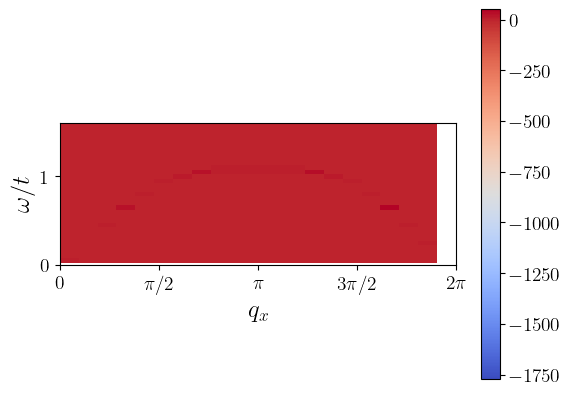

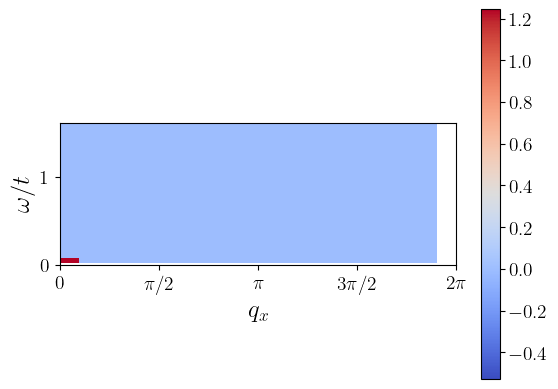

/var/folders/hl/gwthrswx1clcrvqp3t0pjtxw0000gn/T/ipykernel_69229/232122749.py:2: RuntimeWarning: invalid value encountered in divide
  plt.imshow(np.transpose(-1./np.pi*np.imag(spectral_eigenvalues[i,:,0,:])/wvs[:,0,:]),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=1.4,cmap='coolwarm')#,norm=mclr.LogNorm())


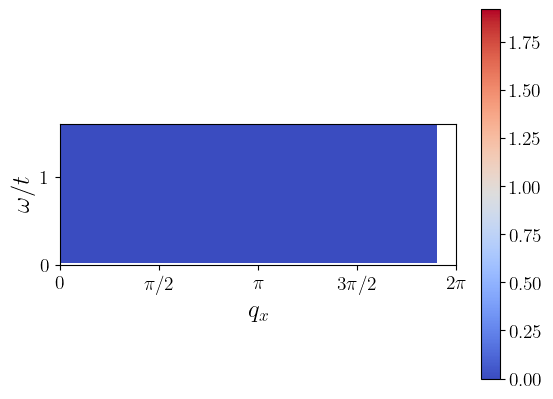

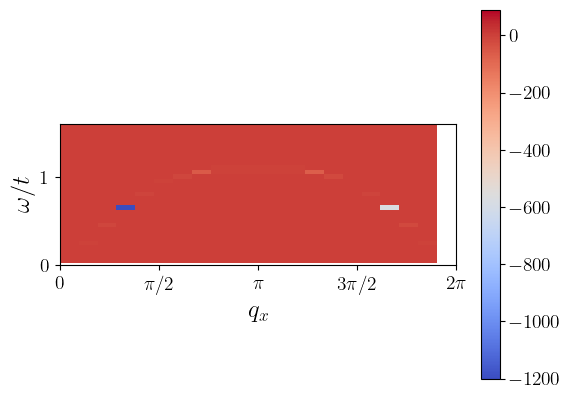

In [93]:
for i in range(4):
    plt.imshow(np.transpose(-1./np.pi*np.imag(spectral_eigenvalues[i,:,0,:])/wvs[:,0,:]),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=1.4,cmap='coolwarm')#,norm=mclr.LogNorm())
    plt.ylabel(r'$\omega/t$')
    plt.ylim(0,3.*J)
    plt.xlabel(r'$q_x$')
    plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
    plt.colorbar()
    #if saveFigs: plt.savefig(figDirectory+"/Magnon_spectrum.pdf",bbox_inches='tight')
    plt.show()